Lets see how two alanine molecules orient themselves using CREST conformer generation.
To do this we will constrain the system in a spherical region using the `SphericalWall` constraint.
We start by setting up a system of two alanine molecules in a relatively small space.

## Initial imports

In [28]:
import scm.plams as plams
import sys
from scm.conformers import ConformersJob
from scm.conformers.plams.plot import plot_conformers
import numpy as np
import matplotlib.pyplot as plt
import os

# this line is not required in AMS2025+
plams.init();

## Single alanine molecule

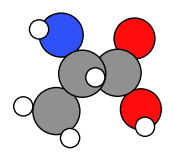

In [2]:
smiles = "CC(N)C(=O)O"
alanine = plams.from_smiles(smiles)
plams.plot_molecule(alanine);

## Initial system: alanine dimer

Pack two alanine molecules in a sphere with a density of 0.5 kg/L.

In [3]:
density = 0.5
mol = plams.packmol(alanine, n_molecules=2, density=density, sphere=True)

Translate the molecule to be centered around the origin (needed for SphericalWall later):

In [4]:
mol.translate(-np.array(mol.get_center_of_mass()))

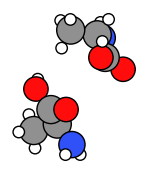

In [5]:
plams.plot_molecule(mol, rotation="0x,0y,90z");

## Calculation setup

To determine the radius of the `SphericalWall` we measure the size of the initial dimer.

In [6]:
dists = plams.distance_array(mol, mol)
max_dist = np.max(dists)
diameter = 1.33 * max_dist
radius = diameter / 2
print(f"Largest distance between atoms: {max_dist:.3f} ang.")
print(f"Radius: {radius:.3f} ang.")

Largest distance between atoms: 8.397 ang.
Radius: 5.584 ang.


Now we can set up the Crest conformer generation job, with the appropriate spherical wall constraining the molecules close together. 

In [7]:
settings = plams.Settings()
settings.input.ams.EngineAddons.WallPotential.Enabled = "Yes"
settings.input.ams.EngineAddons.WallPotential.Radius = radius
settings.input.ams.Generator.Method = "CREST"
settings.input.ams.Output.KeepWorkDir = "Yes"
settings.input.ams.GeometryOptimization.MaxConvergenceTime = "High"
settings.input.ams.Generator.CREST.NCycles = 3  # at most 3 CREST cycles for this demo
settings.input.GFNFF = plams.Settings()

## Run the conformers job

Now we can run the conformer generation job.

In [8]:
job = ConformersJob(molecule=mol, settings=settings)
job.run()
# ConformersJob.load_external("plams_workdir/conformers/conformers.rkf")  # load from disk instead of running the job

[04.02|15:45:58] JOB conformers STARTED
[04.02|15:45:58] JOB conformers RUNNING
[04.02|15:57:08] JOB conformers FINISHED
[04.02|15:57:08] JOB conformers SUCCESSFUL


In [9]:
rkf = job.results.rkfpath()
print(f"Conformers stored in {rkf}")

Conformers stored in /path/plams/examples/ConformersMultipleMolecules/plams_workdir/conformers/conformers.rkf


This job will run for approximately 15 minutes.

## Results
Here we plot the three lowest-energy conformers.

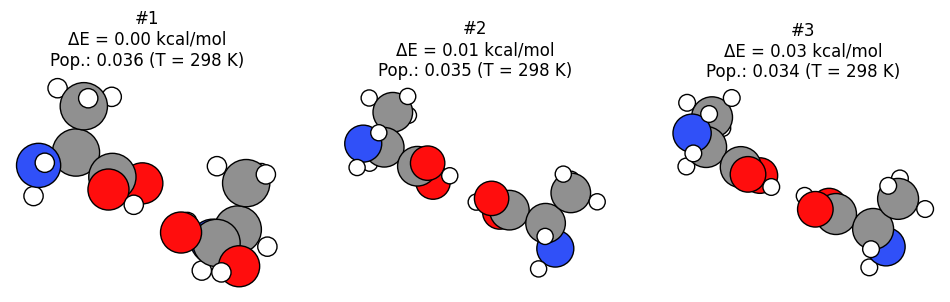

In [10]:
plot_conformers(job);

You can also open the conformers in AMSmovie to browse all conformers 1000+ conformers:

In [24]:
!amsmovie {rkf}

Finally in AMS2025, you can also inspect the conformer data using the JobAnalysis tool.

In [33]:
try:
    from scm.plams import JobAnalysis

    ja = (
        JobAnalysis(standard_fields=None)
        .add_job(job)
        .add_field(
            "Id",
            lambda j: list(range(1, len(j.results.get_conformers()) + 1)),
            display_name="Conformer Id",
            expansion_depth=1,
        )
        .add_field(
            "Energies",
            lambda j: j.results.get_relative_energies("kcal/mol"),
            display_name="E",
            expansion_depth=1,
            fmt=".2f",
        )
        .add_field(
            "Populations",
            lambda j: j.results.get_boltzmann_distribution(298),
            display_name="P",
            expansion_depth=1,
            fmt=".3f",
        )
    )

    # Pretty-print if running in a notebook
    if "ipykernel" in sys.modules:
        ja.display_table(max_rows=20)
    else:
        print(ja.to_table())

except ImportError:
    pass

| Conformer Id | E      | P     |
|--------------|--------|-------|
| 1            | 0.00   | 0.036 |
| 2            | 0.01   | 0.035 |
| 3            | 0.03   | 0.034 |
| 4            | 0.03   | 0.034 |
| 5            | 0.08   | 0.031 |
| 6            | 0.13   | 0.029 |
| 7            | 0.15   | 0.028 |
| 8            | 0.18   | 0.026 |
| 9            | 0.22   | 0.024 |
| 10           | 0.23   | 0.024 |
| ...          | ...    | ...   |
| 1807         | 135.93 | 0.000 |
| 1808         | 137.12 | 0.000 |
| 1809         | 138.93 | 0.000 |
| 1810         | 139.38 | 0.000 |
| 1811         | 140.51 | 0.000 |
| 1812         | 143.04 | 0.000 |
| 1813         | 148.33 | 0.000 |
| 1814         | 152.45 | 0.000 |
| 1815         | 164.99 | 0.000 |
| 1816         | 201.42 | 0.000 |